In [ ]:
!pip install plotly
!pip install pycocotools
!pip install -U kaleido # restart kernel
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Create Image

In [1]:
#Create png on line drawing
import plotly
import plotly.express as px
import plotly.graph_objects as go

filename = './image.png'

# create plot
fig = px.line(x=[1,2,3,4,5])#, color_discrete_sequence = ["black"]) # line
#fig = go.Figure()
#fig.add_vrect(x0=0.9, x1=2) # square
fig.update_layout(yaxis_visible=False, yaxis_showticklabels=False, xaxis_visible=False, xaxis_showticklabels=False, plot_bgcolor=('white') )

# save plot as RGBA png
fig.write_image(filename)

# convert png to grayscale (remove alpha channel)
#from PIL import Image, ImageOps
#ImageOps.grayscale(Image.open(filename)).save(filename)

# Create Image Mask

In [2]:
import itertools
import numpy as np
from PIL import Image
from pycocotools import mask

# From https://newbedev.com/encode-numpy-array-using-uncompressed-rle-for-coco-dataset
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

# open image
image = Image.open(filename)
data = np.asarray(image)

# remove alpha channel
data = data[:, :, 0]

# creat binary mask from array
data[data != 255] = True
data[data == 255] = False
ground_truth_binary_mask = data

# convert to run level encoding
fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)
segmentation = rle

# caclulate area, bbox, height, width
compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
area = int(mask.area(compressed_rle))
bbox = mask.toBbox(compressed_rle).tolist()
image_height = rle.get('size')[0]
image_width  = rle.get('size')[1]

#  Create COCO Annotations json

In [3]:
import json

# https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch

cat_name = 'ok'
cat_id = 1
cats =[{'name':cat_name, 'id':cat_id}]

image_id = 'image_id'
file_name = filename
images = [{'id':image_id, 'width':image_width, 'height':image_height, 'file_name':file_name}]

annotations=[]
ann_id = 23
seg = {
    'segmentation':segmentation, 
    'bbox': bbox,
    'area': area,
    'image_id':image_id, 
    'category_id':cat_id, 
    'iscrowd':0, 
    'id':ann_id
}
annotations.append(seg)

annotations_file = './coco_annotations.json'
root = {'categories':cats, 'images':images,'annotations':annotations}
with open(annotations_file, 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

# View Annotations

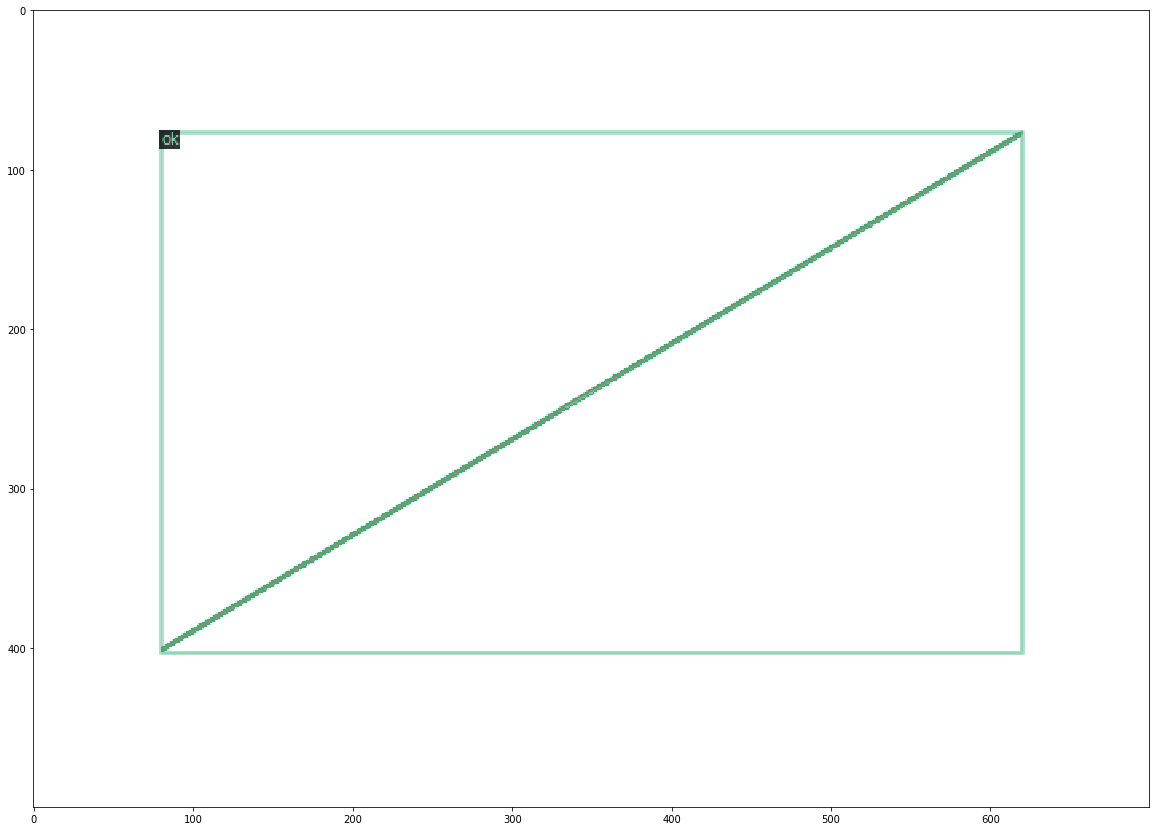

In [4]:
import cv2
import matplotlib.pyplot as plt
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer

annotations_file = annotations_file
image_dir = './'
register_coco_instances('soul_train',{}, annotations_file, image_dir)
train_ds = DatasetCatalog.get('soul_train')
metadata = MetadataCatalog.get('soul_train')

d = train_ds[0]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])